# Neural Network Language Models
1.1 About 
- Language modeling (LM) is the use of various statistical and probabilistic techniques to determine the probability
of a given sequence of words occurring in a sentence. Thus, it may be defined as a probability distribution over
the vocabulary words. In traditional N-gram Language Models, the probabilities of words occurring after a given 
context are defined as: 
This part involves creating a Neural Language Model using standard Deep Learning Frameworks 
with a 5-gram context.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#importing required libraries.....
import torchtext
import nltk
import torch
import re
from torch.utils.data import Dataset, DataLoader
from nltk.util import ngrams
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda'
print(device)

cuda


# Dataset Preprocessing
1.3 Dataset 
1. You need to create the Neural Language Model described above trained on the Auguste_Maquet corpus. 
2. You are expected to clean the data to remove any special characters and use it for training the Neural LM. 
You can use libraries for tokenization. 
3. You can download the corpora from this link. Sample 10,000 sentences as the validation set and 
20,000 sentences as a test set. 

In [3]:
#reading data from text file....
data = []
with open("/content/drive/MyDrive/Auguste_Maquet.txt",'r',encoding='utf-8') as f:
    for line in f:
        if line.strip():
            data.append(line.lower())

In [4]:
data = data[:50000]
n = len(data)
print(n)

50000


In [5]:
#creating a vocabulary
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

#creating vocabulary
clean_text  = re.sub("[^A-Za-z0-9]", " ", "".join(data))
vocab = list(sorted(set(tokenizer(clean_text))))
vocab.append('<end>') #adding extra token

In [6]:
print(f"Number of words in Vocabulary:{len(vocab)}")

Number of words in Vocabulary:17439


In [7]:
#creating dictionary with word_id mappings...
word2id = {word:idx for idx,word in enumerate(vocab)}
id2word = {idx:word for idx,word in enumerate(vocab)}

In [8]:
#splitting the dataset into train and test sets....
train_, test_ = data[:int(.7*(n))],data[int(.7*n):]

In [9]:
print(f"Number of lines in train set : {len(train_)}")
print(f"Number of lines in test set : {len(test_)}")

Number of lines in train set : 35000
Number of lines in test set : 15000


In [10]:
#pre-processing the train and test set by removing special characters.....
train_data = re.sub("[^A-Za-z0-9]", " ", "".join(train_))
test_data  = re.sub("[^A-Za-z0-9]", " ", "".join(test_))

In [11]:
print(f"Sample train data : \n {train_data[:99]}")

Sample train data : 
     the project gutenberg ebook of twenty years after this ebook is for the use of anyone anywhere 


In [12]:
#tokenizng data using inbuild tokenizer from torchtext library......
train_tokens = tokenizer(train_data)
test_tokens  = tokenizer(test_data)

In [13]:
print(f"Sample tokens in train dataset: \n {train_tokens[:9]}")

Sample tokens in train dataset: 
 ['the', 'project', 'gutenberg', 'ebook', 'of', 'twenty', 'years', 'after', 'this']


### Creating n-grams function

In [14]:
#method to creating n-grams dataset where 5-grams will be input and 6th word will be label
def generate_ngrams(token_data,output=True):

    input_grams = []
    #using inbuild ngram generator function from nltk..
    ngram_generator = ngrams(token_data,5)

    #iterating through the generated ngrams...
    for ngram in ngram_generator:
        input_grams.append(list(ngram))
    #creating input lables if requried depending on the case....
    if output:
        output_token = []
        for ngram in range(1,len(input_grams)):
            output_token.append(input_grams[ngram][-1])
        output_token.append('<end>')
        return input_grams,output_token

    return input_grams


In [15]:
#method to convert tokens into token id based on vocabulary.....
def convert_ids(x,y=True):
    input_ids  = []
    output_ids = []
    for sample in x:
        input_ids.append([word2id[word] for word in sample])
    if y:
        for sample in y:
            output_ids.append(word2id[sample])
        return input_ids,output_ids
    return input_ids

In [16]:
#generating n-grams for train and test sets.....
x_train,y_train = generate_ngrams(train_tokens)
x_test,y_test   = generate_ngrams(test_tokens)

In [17]:
#converting generated tokens into token ids as they need to fed into model....
x_train_ids,y_train_ids  = convert_ids(x_train,y_train)
x_test_ids,y_test_ids  = convert_ids(x_test,y_test)

In [18]:
def dataset_creation(X,y,batch_size=64):
    tensor_x, tensor_y = torch.tensor(X),torch.tensor(y)
    return DataLoader(list(zip(tensor_x,tensor_y)),batch_size=batch_size,shuffle=False)

In [23]:
#tmodel parameters
batch_size = 1
epochs     = 10
learning_rate = 1e-3

vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
input_size = 5

In [24]:
train_loader = dataset_creation(x_train_ids,y_train_ids,batch_size)
val_loader   = dataset_creation(x_test_ids,y_test_ids,batch_size)

# Feed Forward Language model building
1.2 Model Architecture 
The architecture of the Language Model is described below: 
1. The input to the Neural Network would be the pre-trained embeddings of the previous 5-words 
concatenated together(5-gram embedding). 
2. These embeddings would pass into a Hidden Layer which would output a 300-dimension vector. 
3. The output of the first Hidden Layer would go into another Hidden Layer, which would output a vector of
size vocabulary. 
4. This vector would be passed to a Softmax Layer, which would output the probabilities of the entire 
vocabulary occurring after the given 5-words. 
5. The vocabulary should consist of all the words that occur any number of times in the training data. 
Unknown words can be handled with a <UNK> token.
6. You are allowed to use only Pytorch as the Deep Learning Framework for this assignment. 7. You can use 
any pre-trained embeddings as input to the Neural Network - word2vec, GloVe, fasttext, etc. 

In [34]:
class LanguageModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LanguageModel, self).__init__()
        self.embedding_dim = embedding_dim
        # The embedding layer that takes the input n-gram and outputs a vector of embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # The first hidden layer that takes the embedding vector and outputs a vector of hidden_dim
        self.hidden1 = nn.Linear(embedding_dim * 5, hidden_dim)
        # The second hidden layer that takes the hidden vector and outputs a vector of vocab_size
        self.hidden2 = nn.Linear(hidden_dim, vocab_size)
        # The softmax layer that takes the output vector and outputs a probability distribution over the vocabulary
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs):
        # Embed the inputs and reshape them to match the expected shape of the first hidden layer
        embeds = self.embedding(inputs)
        embeds = embeds.view(-1, self.embedding_dim * 5)
        # Pass the embeddings through the first hidden layer and apply a ReLU activation function
        hidden1 = self.hidden1(embeds)
        hidden1 = F.relu(hidden1)
        # Pass the hidden vector through the second hidden layer
        hidden2 = self.hidden2(hidden1)
        # Pass the output vector through the softmax layer and return the result
        output = self.softmax(hidden2)
        return output

In [35]:
model = LanguageModel(embedding_dim,hidden_dim,vocab_size)
model = model.to(device)

In [36]:
print(f"Model Architecture created : \n {model}")

Model Architecture created : 
 LanguageModel(
  (embedding): Embedding(17439, 300)
  (hidden1): Linear(in_features=1500, out_features=300, bias=True)
  (hidden2): Linear(in_features=300, out_features=17439, bias=True)
  (softmax): LogSoftmax(dim=1)
)


# Feed Forward Language Model Training

In [37]:
#defining loss and optimizer functions for model
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)

In [32]:
def perplexity(loss):
    '''method for calculating the perpelxity
        of model output'''
    return torch.exp(loss)

def train(model,data_loader):
    '''Method that inputs a dataloader and
    train model for one epoch on dataset
    '''
    # Set the model to training mode
    model.train()
    # Initialize the total loss
    total_loss = 0
    # Loop over the batches
    for input_seq, target_seq in data_loader:
        # Move the input and target sequences to the device
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass the input sequence through the model and get the output
        output = model(input_seq)
        # Compute the loss between the output and the target sequence
        loss = criterion(output, target_seq)
        # Backward pass the loss and update the gradients
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Accumulate the total loss
        total_loss += loss
    #training loss per batch....
    total_loss = total_loss / len(data_loader)
    #train perplexity per batch....
    total_pxl  = perplexity(total_loss)
    # Return the average loss per batch
    return total_loss.item(),total_pxl.item()

def evaluate(model,data_loader):

    '''Method that inputs a dataloader and
    evaluated model for one epoch on dataset
    '''
    #setting model in evaluation model
    model.eval()

    #validation_loss
    val_loss = 0

    #iterating over batches
    for input_seq, target_seq in data_loader:

        #placing them on device
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)

        #forward pass of input sequence to get output....
        output = model(input_seq)

        #calculating loss for current batch....
        loss = criterion(output,target_seq)
        #accumaulating total loss....
        val_loss += loss

    #training loss per batch....
    val_loss = val_loss / len(data_loader)
    #train perplexity per batch....
    val_pxl  = perplexity(val_loss)
    # Return the average loss per batch
    return val_loss.item(),val_pxl.item()


def predict(model,text):
    '''Method for predictin a piece of text
    as input
        '''
    #tokenizing the text using tokenizer....
    tokens       = tokenizer(text)
    #generating 5-grams based on text.....
    input_ngrams = generate_ngrams(tokens,False)
    #converting them into input-ids for model input....
    input_ids    = convert_ids(input_ngrams,False)
    #converting them to torch tensors.....
    input_ids    = torch.tensor(input_ids).to(device)

    #setting model into evaluation mode...
    model.eval()
    #disabling all gradients while predicting....
    with torch.no_grad():
        output = model(input_ids)
        index = output.argmax(dim=1)

    #printing output corresponding to each  n-gram generated.....
    for x,y in zip(input_ngrams,index):
        print(*x,id2word[y.item()])

In [30]:
embed_lm_train_loss = []
embed_lm_valid_loss = []
embed_lm_train_pxl  = []
embed_lm_valid_pxl  = []
for epoch in range(1, epochs + 1):
    # Train the model on the training set and get the average loss
    train_loss,train_pxl = train(train_loader)
    embed_lm_train_loss.append(train_loss)
    embed_lm_train_pxl.append(train_pxl)
    # Evaluate the model on the validation set and get the average loss
    val_loss,val_pxl = evaluate(val_loader)
    embed_lm_valid_loss.append(val_loss)
    embed_lm_valid_pxl.append(val_pxl)
    # Print the epoch, training loss, and validation loss
    print(f"Epoch: {epoch}, Training loss: {train_loss:.4f}, Train perplexity : {train_pxl:.4f},\
        Validation loss: {val_loss:.4f},Validation Perplexity : {val_pxl:.4f}")


Epoch: 1, Training loss: 7.1096, Train perplexity : 1223.6295,        Validation loss: 6.9593,Validation Perplexity : 1052.8772
Epoch: 2, Training loss: 6.8502, Train perplexity : 944.0771,        Validation loss: 6.7640,Validation Perplexity : 866.1257
Epoch: 3, Training loss: 6.6696, Train perplexity : 788.0577,        Validation loss: 6.6263,Validation Perplexity : 754.6558
Epoch: 4, Training loss: 6.5346, Train perplexity : 688.5342,        Validation loss: 6.5196,Validation Perplexity : 678.3189
Epoch: 5, Training loss: 6.4268, Train perplexity : 618.1986,        Validation loss: 6.4354,Validation Perplexity : 623.5129
Epoch: 6, Training loss: 6.3383, Train perplexity : 565.8448,        Validation loss: 6.3662,Validation Perplexity : 581.8643
Epoch: 7, Training loss: 6.2636, Train perplexity : 525.1321,        Validation loss: 6.3074,Validation Perplexity : 548.5894
Epoch: 8, Training loss: 6.1993, Train perplexity : 492.4062,        Validation loss: 6.2576,Validation Perplexity :

# Feed Forward Language Model Results

In [61]:
def plot_metrics(train,valid,name,epochs=10):
    epochs = range(1,epochs+1)
    plt.plot(epochs,train,label='Train '+name)
    plt.plot(epochs,valid,label='Valid '+name)

    plt.title('Traing and Validation '+name+'s')
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.legend(loc='best')
    plt.show()

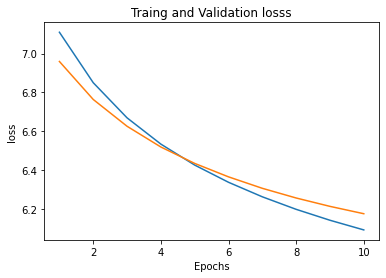

In [45]:
plot_metrics(embed_lm_train_loss,embed_lm_valid_loss,'loss')

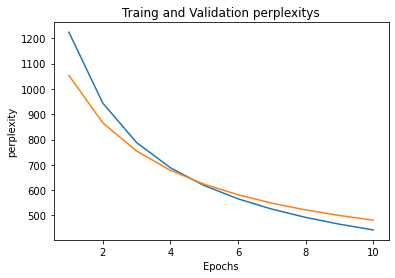

In [46]:
plot_metrics(embed_lm_train_pxl,embed_lm_valid_pxl,'perplexity')

In [58]:
predict(model,'hello there I am in')

hello there i am in the


In [59]:
predict(model,'there i am in the')

there i am in the corner


In [60]:
predict(model, 'i am in the first')

i am in the first place


# LSTM Model Building
2.2 Model Architecture 
The architecture of the Language Model is described below: 
1. The Neural Network would consist of repeating layers in an LSTM structure. 
2. The input to each layer would consist of the hidden layer and cell state output of the previous state, along
with the embedding of the current word. 
3. The 300-dimension output would be put into a Linear layer, which will transform it to a vector of dimension
of size vocabulary. Then, that to SoftMax-layer, which would provide the probability distribution over the
entire vocabulary. 

In [72]:
class LSTMLanguageModel(nn.Module):
    def __init__(self,input_size,vocab_size,hidden_dim):
        super(LSTMLanguageModel,self).__init__()
        self.input_size    = input_size
        self.hidden_dim    = hidden_dim
        #adding LSTM layer
        self.lstm   = nn.LSTM(input_size,hidden_dim,batch_first= True)
        #linear layer
        self.linear = nn.Linear(hidden_dim,vocab_size)
        #softmax layer
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,inputs):
        inputs = inputs.to(torch.float)
        #lstm layer
        lstm_out,hidden = self.lstm(inputs,None)
        #linear layer
        hidden2 = self.linear(lstm_out)
        #output layer
        output  = self.softmax(hidden2)

        return output

In [73]:
lstm_model = LSTMLanguageModel(input_size,vocab_size,hidden_dim)
lstm_model = lstm_model.to(device)
#defining loss and optimizer functions for model
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(), lr=.001)

In [76]:
print(f'Model Architecture : \n{lstm_model}')

Model Architecture : 
LSTMLanguageModel(
  (lstm): LSTM(5, 300, batch_first=True)
  (linear): Linear(in_features=300, out_features=17439, bias=True)
  (softmax): LogSoftmax(dim=1)
)


# LSTM Model Training

In [77]:
lstm_train_loader = dataset_creation(x_train_ids,y_train_ids)
lstm_valid_loader = dataset_creation(x_test_ids,y_test_ids)

In [78]:
lstm_lm_train_loss = []
lstm_lm_valid_loss = []
lstm_lm_train_pxl  = []
lstm_lm_valid_pxl    = []

for epoch in range(1, epochs + 1):
    # Train the model on the training set and get the average loss
    train_loss,train_pxl = train(lstm_model,lstm_train_loader)
    lstm_lm_train_loss.append(train_loss)
    lstm_lm_train_pxl.append(train_pxl)

    # Evaluate the model on the validation set and get the average loss
    val_loss,val_pxl = evaluate(lstm_model,lstm_valid_loader)
    lstm_lm_valid_loss.append(val_loss)
    lstm_lm_valid_pxl.append(val_pxl)


    # Print the epoch, training loss, and validation loss
    print(f"Epoch: {epoch}, Training loss: {train_loss:.4f}, Train perplexity : {train_pxl:.4f}, Validation loss: {val_loss:.4f},Validation Perplexity : {val_pxl:.4f}")

Epoch: 1, Training loss: 8.3900, Train perplexity : 4402.9492, Validation loss: 7.6855,Validation Perplexity : 2176.4629
Epoch: 2, Training loss: 7.4322, Train perplexity : 1689.5092, Validation loss: 7.3619,Validation Perplexity : 1574.8519
Epoch: 3, Training loss: 7.1939, Train perplexity : 1331.2629, Validation loss: 7.2333,Validation Perplexity : 1384.7455
Epoch: 4, Training loss: 7.0705, Train perplexity : 1176.7788, Validation loss: 7.1563,Validation Perplexity : 1282.1167
Epoch: 5, Training loss: 6.9884, Train perplexity : 1083.9355, Validation loss: 7.1037,Validation Perplexity : 1216.4094
Epoch: 6, Training loss: 6.9308, Train perplexity : 1023.2961, Validation loss: 7.0664,Validation Perplexity : 1171.9529
Epoch: 7, Training loss: 6.8883, Train perplexity : 980.7163, Validation loss: 7.0375,Validation Perplexity : 1138.5908
Epoch: 8, Training loss: 6.8549, Train perplexity : 948.5361, Validation loss: 7.0149,Validation Perplexity : 1113.0605
Epoch: 9, Training loss: 6.8280, T

# LSTM Model Results

In [79]:
predict(lstm_model,'hello there I am in')

hello there i am in the


In [80]:
predict(lstm_model,'there i am in the')

there i am in the the


In [81]:
predict(lstm_model,'i am in the the')

i am in the the the


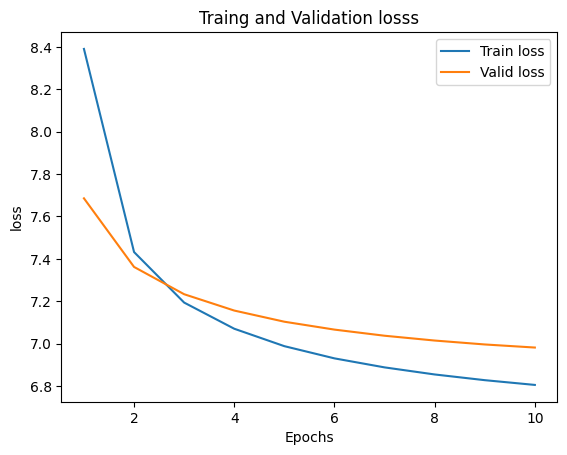

In [82]:
plot_metrics(lstm_lm_train_loss,lstm_lm_valid_loss,'loss')

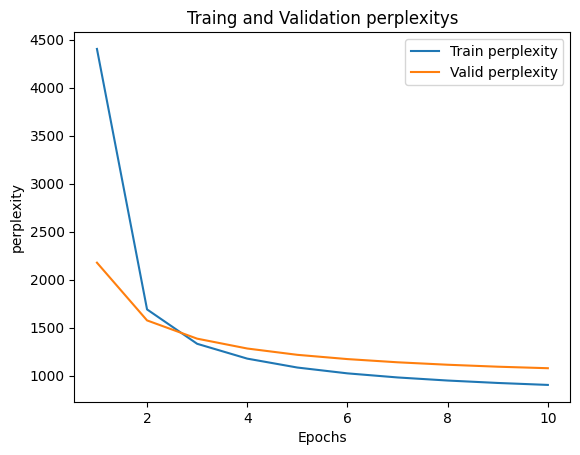

In [83]:
plot_metrics(lstm_lm_train_pxl,lstm_lm_valid_pxl,'perplexity')

In [84]:
torch.save(lstm_model,"trained_lstm_model.pth")

## Transformer Decoder Model

In [25]:
class Head(nn.Module):
    ''' Method implementing the attention head
        in the multi-head attention with masking
        since it belongs to decoder block
        '''
    def __init__(self,n_embed,head_size,block_size):
        super().__init__()
        self.key    = nn.Linear(n_embed,head_size,bias=False)
        self.value  = nn.Linear(n_embed,head_size,bias=False)
        self.query  = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))

    def forward(self,x):

        B,T,C = x.shape

        k = self.key(x) # (B,T,hs)
        q = self.query(x) #(B,T,hs)
        # print(k.shape)
        wei = q @ k.transpose(-2,-1) # (B,T,hs) (B,T,hs) -----> (B,T,T)
        wei = wei * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
        wei = F.softmax(wei,dim=-1)

        v  = self.value(x)
        out = wei@v #(B,T,T) , (B,T,hs) ---> (B,T,hs)

        return out

class MultiHeadAttention(nn.Module):
    '''Multihead Attention block where we combine
    individual attention heads and concatenate them
    to create Mult-Head Attention'''
    def __init__(self,num_heads,block_size,head_size):
        super().__init__()
        n_embed    = num_heads * head_size
        self.heads = nn.ModuleList([Head(n_embed,head_size,block_size) for _ in range(num_heads)])
        self.proj  = nn.Linear(n_embed,n_embed)

    def forward(self,x):
        out = torch.cat([h(x) for h in self.heads],dim=-1)
        out = self.proj(out)

        return out



class FeedForward(nn.Module):
    '''
    Method that implements feed forward neural network
    part of transformer model
    '''
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4*n_embed),
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed)  #skip connection from the multihead attention
        )

    def forward(self,x):
        return self.net(x)



class Block(nn.Module):
    '''Method implements a typical decoder block
    with mult-head attention block, feed-forward neural network
    '''
    def __init__(self,n_embed,n_head,block_size) :
        super().__init__()
        head_size = n_embed // n_head
        self.mas  = MultiHeadAttention(n_head,block_size,head_size=head_size)
        self.ffn  = FeedForward(n_embed=n_embed)
        self.ln1  = nn.LayerNorm(n_embed) #Layer normalization
        self.ln2  = nn.LayerNorm(n_embed) #Layer Normalization

    def forward(self,x):

        x  =  x + self.mas(self.ln1(x)) #applying LN before sending it into Multi-Head attention
        x  =  x + self.ffn(self.ln2(x)) # applying LN before sending it to FeedForward Network

        return x

In [26]:
class TransformerDecoder(nn.Module):
    '''Method implementing transformer decoder block
    with MHA and FFN as two blocks
    '''
    def __init__(self,block_size,n_embed,vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size,n_embed)  #(B,T) ---> (B,T,n_embeds)
        self.positional_embedding_table = nn.Embedding(block_size,n_embed) #(B,T) ---> (T,n_embds)
        self.block = nn.Sequential(
            Block(n_embed,2,block_size),
            nn.LayerNorm(n_embed))
        self.lm_head = nn.Linear(n_embed,vocab_size) #(B,T,head_size) ---> (B,T,vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)



    def forward(self,idx):

        B,T = idx.shape
        #logits and targets are both (B,T) tensors of integers
        tokn_embd = self.token_embedding_table(idx) #outputs of size (B,T,embed_size)
        pos_embd  = self.positional_embedding_table(torch.arange(T,device=device)) # (T,embed_size)
        x = tokn_embd + pos_embd
        x = self.block(x)
        logits = self.lm_head(x) # (B,T,vocab_size)
        logits = logits[:,0,:]
        output = self.softmax(logits)

        return output


In [27]:
decoder_model = TransformerDecoder(input_size,embedding_dim,vocab_size)
decoder_model = decoder_model.to(device)

In [28]:
print(f"Architecture of Decoder Transformer Model : \n{decoder_model}")

Architecture of Decoder Transformer Model : 
TransformerDecoder(
  (token_embedding_table): Embedding(17439, 300)
  (positional_embedding_table): Embedding(5, 300)
  (block): Sequential(
    (0): Block(
      (mas): MultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 x Head(
            (key): Linear(in_features=300, out_features=150, bias=False)
            (value): Linear(in_features=300, out_features=150, bias=False)
            (query): Linear(in_features=300, out_features=150, bias=False)
          )
        )
        (proj): Linear(in_features=300, out_features=300, bias=True)
      )
      (ffn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=300, out_features=1200, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1200, out_features=300, bias=True)
        )
      )
      (ln1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    )
    (1): LayerN

# Transformer Decoder Training

In [29]:
#defining loss and optimizer required for the model......
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(decoder_model.parameters(), lr=learning_rate)

In [30]:
#creating a dataset loader for decoder based trasformer models...
decoder_train_loader = dataset_creation(x_train_ids,y_train_ids,batch_size=32)
decoder_test_loader = dataset_creation(x_test_ids,y_test_ids,batch_size=32)

In [33]:
decoder_lm_train_loss = []
decoder_lm_valid_loss = []
decoder_lm_train_pxl  = []
decoder_lm_valid_pxl    = []

for epoch in range(1, epochs + 1):
    # Train the model on the training set and get the average loss
    train_loss,train_pxl = train(decoder_model,decoder_train_loader)
    decoder_lm_train_loss.append(train_loss)
    decoder_lm_train_pxl.append(train_pxl)

#     # Evaluate the model on the validation set and get the average loss
    val_loss,val_pxl = evaluate(decoder_model,decoder_test_loader)
    decoder_lm_valid_loss.append(val_loss)
    decoder_lm_valid_pxl.append(val_pxl)


    # Print the epoch, training loss, and validation loss
    print(f"Epoch: {epoch}, Training loss: {train_loss:.4f}, Train perplexity : {train_pxl:.4f} Validation loss: {val_loss:.4f}, Validation Perplexity : {val_pxl:.4f}")


# Transformer Decoder Results

In [ ]:
predict(decoder_model,'hello there I am in')

hello there i am in the


In [ ]:
predict(decoder_model,'there i am in the')

there i am in the the


In [ ]:
predict(decoder_model,'i am in the the')

i am in the the the


In [ ]:
import pickle

In [ ]:
with open('decoder_model.pkl','wb') as f:
    pickle.dump(zip(decoder_lm_train_loss,decoder_lm_train_pxl,decoder_lm_valid_loss,decoder_lm_valid_pxl),f)

In [ ]:
torch.save(decoder_model,"trained_decoder_model.pth")

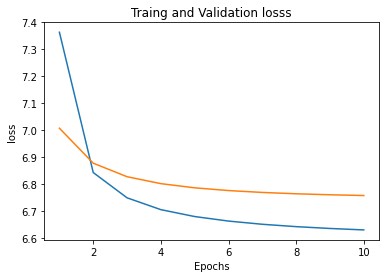

In [ ]:
plot_metrics(decoder_lm_train_loss,decoder_lm_valid_loss,'loss')
#Blue -- Training Loss
#Orange-- Validation loss

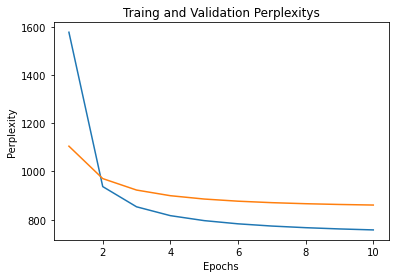

In [ ]:
plot_metrics(decoder_lm_train_pxl,decoder_lm_valid_pxl,'Perplexity')
#Blue -- Training perplexity
#Orange-- Validation perplexity

In [ ]:
import pickle
def unzip_metrics(filename):

    train_loss =[]
    train_pxl  = []
    val_loss   = []
    val_pxl    = []
    with open(filename,'rb') as f:
        data = pickle.load(f)
    for a,b,c,d in data:
#         print(a,b,c,d)
        train_loss.append(a)
        train_pxl.append(b)
        val_loss.append(c)
        val_pxl.append(d)
    return train_loss,train_pxl,val_loss,val_pxl

In [ ]:
lm_train_loss,lm_train_pxl,lm_val_loss,lm_val_pxl = unzip_metrics('model_metric.pkl')
lstm_train_loss,lstm_train_pxl,lstm_val_loss,lstm_val_pxl = unzip_metrics('lstm_mode.pkl')


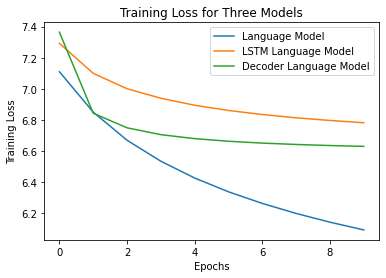

In [ ]:
# epochs = range(1,epochs+1)
# plt.plot(epochs,label='Training Loss')
plt.plot(lm_train_loss,label = 'Language Model')
plt.plot(lstm_train_loss,label = 'LSTM Language Model')
plt.plot(decoder_lm_train_loss,label = 'Decoder Language Model')
plt.title('Training Loss for Three Models')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

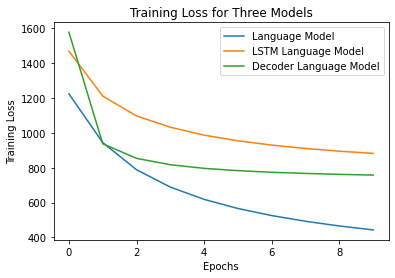

In [ ]:
plt.plot(lm_train_pxl,label = 'Language Model')
plt.plot(lstm_train_pxl,label = 'LSTM Language Model')
plt.plot(decoder_lm_train_pxl,label = 'Decoder Language Model')
plt.title('Training Loss for Three Models')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()